# Kepler's Third Law

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

We Use the Cumulative Database of Objects of Interest of the Kepler Exoplanet Observatory at https://exoplanetarchive.ipac.caltech.edu/docs/data.html

In this notebook we perform a Linear Fit in order to obtain Kepler's Third Law.

In [2]:
# Load the exoplanet database
data_url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&select=koi_period,koi_sma,koi_smass&format=csv"
df_kepler = pd.read_csv(data_url)

Dataframe Cleaning

In [3]:
nans_per_column=df_kepler.isna().sum(axis=0)
nans_per_column

koi_period      0
koi_sma       363
koi_smass     363
dtype: int64

Drop All NaNs

In [4]:
df_kepler_clean=df_kepler.dropna().reset_index(drop=True)
df_kepler_clean

,koi_period,koi_sma,koi_smass
0,9.488036,0.0853,0.919
1,54.418383,0.2734,0.919
2,19.899140,0.1419,0.961
3,1.736952,0.0267,0.836
4,2.525592,0.0374,1.095
...,...,...,...
9196,0.527699,0.0128,1.005
9197,1.739849,0.0290,1.075
9198,0.681402,0.0157,1.104
9199,333.486169,1.2233,2.190


## Pearson Correlation Matrix

In [5]:
df_kepler_clean.corr()

,koi_period,koi_sma,koi_smass
koi_period,1.000000,0.871817,-0.004991
koi_sma,0.871817,1.000000,0.058292
koi_smass,-0.004991,0.058292,1.000000


Text(0.5, 1.0, 'Pearson Correlation Table')

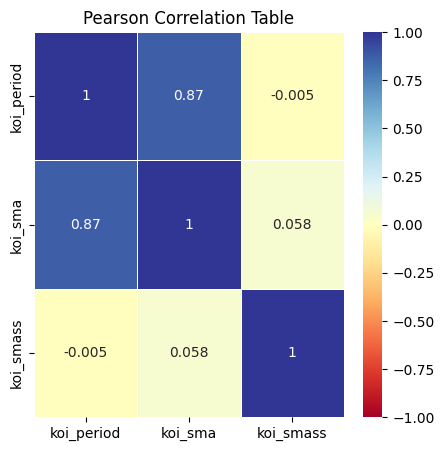

In [6]:
plt.figure(figsize=(5,5))
ax=sns.heatmap(df_kepler_clean.corr(), vmin=-1,vmax=1, annot=True,cmap="RdYlBu",linewidths=0.5)
ax.set_title('Pearson Correlation Table')

From the Pearson Correlation Matrix, we can conclude that there is a strong correlation between the semi-major axis and the period of the objects. In fact such a relation exists and it is known as Kepler's Third Law, that states that the square of the period $T$ is proportional to the cube of the semi-major axis $a$, and inversely proportional to the mass $M$ of the host star

$$T^2=C \frac{a^3}{M},$$

where $C$ is a constant.

Taking the natural logaritm on both sides, we can obtain a linear relation of the form

$$\log M=3 \log a-2\log T+\log C,$$

that we can fit with a multiple linear regression


## Filtering and Transformation of the Data

In [7]:
def filter(df,col,iqr_score):
  iqr_col=df[col].quantile(0.75)-df[col].quantile(0.25)
  filter_lower=df[col]>df[col].quantile(0.25)-(iqr_col*iqr_score)
  filter_upper=df[col]<df[col].quantile(0.75)+(iqr_col*iqr_score)
  return df[filter_lower & filter_upper]

In [8]:
df_k1=filter(df_kepler_clean,'koi_smass',2)
df_k2=filter(df_k1,'koi_sma',2)
df_k3=filter(df_k2,'koi_period',2)
df_k4=df_k3.copy()

Conversion to SI units and logarithm

In [9]:
df_k4['ln_mass']=(df_k3['koi_smass'].apply(lambda x: x*1.98847*10**(30))).apply(np.log)
df_k4['ln_axis']=(df_k3['koi_sma'].apply(lambda x: x*1.49597870700*10**(11))).apply(np.log)
df_k4['ln_period']=(df_k3['koi_period'].apply(lambda x: x*86400)).apply(np.log)

In [10]:
df_k5=df_k4.drop(['koi_smass','koi_sma','koi_period'],axis=1)

The resulting dataframe contains the natural logarithm of the original variables

In [11]:
df_k5.head()

,ln_mass,ln_axis,ln_period
0,69.680449,23.269636,13.616775
1,69.680449,24.434397,15.363445
2,69.725137,23.778584,14.357419
3,69.585792,22.108125,11.918875
4,69.855673,22.445132,12.293218


We can now verify that there is an exact linear correlation between $\log a$ and $\log T$:

Text(0.5, 1.0, 'Pearson Correlation Table')

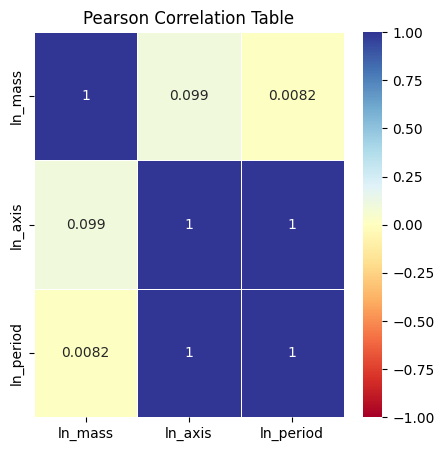

In [12]:
plt.figure(figsize=(5,5))
ax=sns.heatmap(df_k5.corr(), vmin=-1,vmax=1, annot=True,cmap="RdYlBu",linewidths=0.5)
ax.set_title('Pearson Correlation Table')

## Linear Regression

We Identify the Independent and Dependent Variables

In [13]:
X=df_k5[['ln_axis','ln_period']] # Independent Variables
y=df_k5['ln_mass'] # Dependent Variable

We separate the data in Training and Test sets

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.3,shuffle=True)

Multiple Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression

In [17]:
lr=LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

The Coefficients of the Regression coincide with the theoretical model for Kepler's Third Law

$$\log M=3 \log a-2\log T+\log C,$$

In [18]:
lr.coef_

array([ 2.93341044, -1.9559006 ])

In [19]:
log_const=lr.intercept_
log_const

28.054012358588636

We verify if the regression is successfull by calculating its Coefficient of Determination $R^2$ with respect to the test sets

In [20]:
lr.score(X_test,y_test)

0.9990013081123518

Predictions of the model

In [21]:
ln_mass_pred=lr.predict(X)

Comparison of data vs predictions

Text(0, 0.5, '$\\log(M)$')

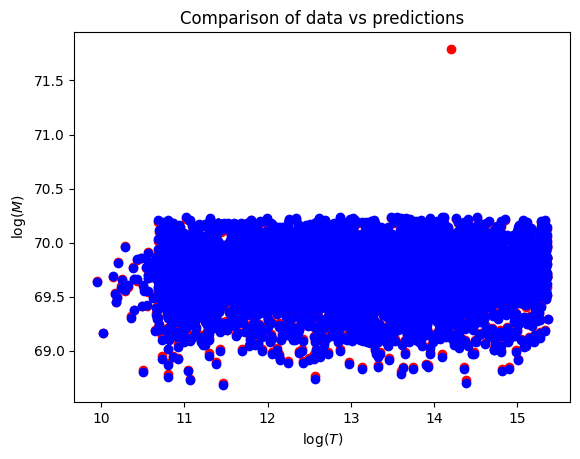

In [22]:
plt.scatter(X['ln_period'],ln_mass_pred,c='r')
plt.scatter(X['ln_period'],y,c='b')
plt.title('Comparison of data vs predictions')
plt.xlabel(r'$\log(T)$')
plt.ylabel(r'$\log(M)$')


In fact, In this database, the semi-major axis of the object is calculated using Kepler's Third Law. This analysis shows that there is one outlier pint in which the law was incorrecly used. 

Cross Validation

In [23]:
from sklearn.model_selection import cross_validate

In [90]:
scores_1=cross_validate(lr,X,y,scoring='r2')
scores_1

{'fit_time': array([0.03268099, 0.00579906, 0.0106771 , 0.00622797, 0.00617671]),
 'score_time': array([0.00824857, 0.00289583, 0.00301123, 0.00546622, 0.00310612]),
 'test_score': array([0.99897863, 0.99900445, 0.99918332, 0.9373306 , 0.99909247])}

In [91]:
print(f'Score of the Linear Regression model: {scores_1["test_score"].mean():.3f} +/- {scores_1["test_score"].std():.3f}')

Score of the Linear Regression model: 0.987 +/- 0.025


Now we implement other Regression Algorithms in order to compare them with the successful Linear Regression obtained above.

## Linear Regression using an Artificial Neural Network with a single Neuron

In [25]:
import tensorflow as tf

We build a the model as an Artificial Neural Network that admits a two component argument

In [26]:
layer0=tf.keras.layers.Dense(units=1,input_dim=2,activation='linear')
model= tf.keras.Sequential([layer0])

In [65]:
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.2),
              metrics=['mean_squared_error'])

In [84]:
history=model.fit(X_train,y_train,epochs=100,verbose=True,validation_split=0.01)

Epoch 1/100
150/150 [==============================] - 0s 2ms/step - loss: 0.0609 - mean_squared_error: 0.0609 - val_loss: 0.5730 - val_mean_squared_error: 0.5730
Epoch 2/100
150/150 [==============================] - 1s 3ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 3/100
150/150 [==============================] - 0s 3ms/step - loss: 0.0290 - mean_squared_error: 0.0290 - val_loss: 0.0424 - val_mean_squared_error: 0.0424
Epoch 4/100
150/150 [==============================] - 0s 3ms/step - loss: 0.0349 - mean_squared_error: 0.0349 - val_loss: 0.0331 - val_mean_squared_error: 0.0331
Epoch 5/100
150/150 [==============================] - 1s 5ms/step - loss: 0.1108 - mean_squared_error: 0.1108 - val_loss: 0.1098 - val_mean_squared_error: 0.1098
Epoch 6/100
150/150 [==============================] - 1s 5ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 7/100
150/150 [=

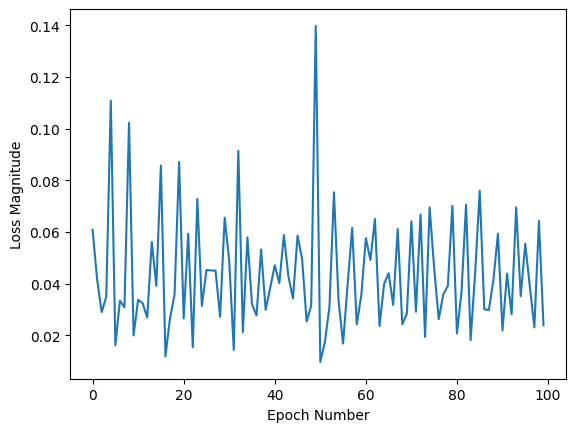

In [85]:
plt.plot(history.history['loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss Magnitude')
plt.show()

Score

In [86]:
from sklearn.metrics import r2_score

In [87]:
y_pred=model.predict(X_test)

65/65 [==============================] - 0s 1ms/step


In [88]:
r2_score(y_test,y_pred)

0.9937662056968165

In [89]:
layer0.get_weights()

[array([[ 3.1867669],
        [-2.1269262]], dtype=float32),
 array([24.492508], dtype=float32)]

## Decision Tree Regressor (Overfitting)

In [76]:
from sklearn.tree import DecisionTreeRegressor

In [77]:
dtr=DecisionTreeRegressor()
dtr.fit(X_train,y_train)

DecisionTreeRegressor()

We can see that this Algorithm is basically perfect for the description of the Train Sets

In [78]:
dtr.score(X_train,y_train)

0.9999998436436452

However, it does not perform well when new data is analyzed:

In [79]:
dtr.score(X_test,y_test)

0.9506488685387502

In [92]:
scores_2=cross_validate(dtr,X,y,scoring='r2')
scores_2

{'fit_time': array([0.17390919, 0.17038822, 0.36442685, 0.37146521, 0.29301119]),
 'score_time': array([0.0121057 , 0.02488112, 0.0314014 , 0.03661251, 0.02607822]),
 'test_score': array([0.95506574, 0.95788669, 0.95134582, 0.94356105, 0.95908928])}

In [93]:
print(f'Score of the Decision Tree Regressor model: {scores_2["test_score"].mean():.3f} +/- {scores_2["test_score"].std():.3f}')

Score of the Decision Tree Regressor model: 0.953 +/- 0.006


This is a classic example of overfitting

## K-Neighbors Regressor

In [80]:
from sklearn.neighbors import KNeighborsRegressor

In [81]:
knr=KNeighborsRegressor()
knr.fit(X_train,y_train)

KNeighborsRegressor()

In [83]:
knr.score(X_test,y_test)

0.9734089630631747

In [95]:
scores_3=cross_validate(knr,X,y,scoring='r2')
scores_3

{'fit_time': array([0.00944972, 0.00458479, 0.00415206, 0.00574827, 0.00602269]),
 'score_time': array([0.0082016 , 0.00549746, 0.00543356, 0.01045585, 0.00542665]),
 'test_score': array([0.97413215, 0.98192296, 0.97628617, 0.96405593, 0.97743042])}

In [96]:
print(f'Score of the K-Neighbors Regressor model: {scores_3["test_score"].mean():.3f} +/- {scores_3["test_score"].std():.3f}')

Score of the K-Neighbors Regressor model: 0.975 +/- 0.006


# Gravitational Constant Estimation from the Exoplanet Data

The constant $C$ in Kepler's Third Law is related to the gravitational constant $G$ according to $G=4\pi^2/C$. In order to extract $G$, We first calculate
$$\log C=\log M-3 \log a+2\log T$$
from the data

In [42]:
wt=[1.0,-3.0,2.0]
log_c=df_k5.iloc[:,:].mul(wt, axis=1).sum(axis=1)

And then we can find the estimate of $G$ for each exoplanet

In [43]:
g_const=log_c.apply(lambda x: 4*np.pi**2/np.exp(x))

In [44]:
g_const[0]

6.679876274655611e-11

In [45]:
g_const.min()

6.359525666557502e-11

In [46]:
g_const.max()

6.013451810935543e-10

From the above result we can identify the outlier point in the data. We perform a filter to exclude it:

In [ ]:
g_filtered = g_const[ g_const < 1e-10]

And we can verify that there was only one outlier:

In [48]:
len(g_const)-len(g_filtered)

1

Finally, we visualize the distribution obtained for $G$

[Text(0, 0.5, 'Frequency')]

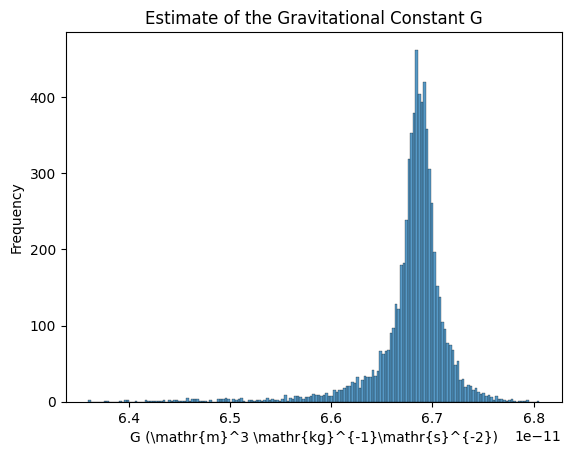

In [49]:
ax=sns.histplot(g_filtered)
ax.set_title ('Estimate of the Gravitational Constant G')
ax.set(xlabel=r'G (\mathr{m}^3 \mathr{kg}^{-1}\mathr{s}^{-2})')
ax.set(ylabel='Frequency')

And verify that its distribution is indeed normal

In [97]:
g_filtered.skew(),g_filtered.kurtosis()

(0, 0)

In [51]:
print(f'The estimate for the Gravitational constant $G$ using the Kepler Data is {g_filtered.mean()} +/- {g_filtered.std()}')

The estimate for the Gravitational constant $G$ using the Kepler Data is 6.679399607297097e-11 +/- 3.8277457656346335e-13
